In [7]:
import numpy as np
import pandas as pd 
import os
import keras
import matplotlib.pyplot as plt
import seaborn as sns

print(keras.__version__)

print("{} paintings".format(len(os.listdir("../input/resized/resized"))))

2.2.4
8355 paintings


# Building an artist classifier for vector encoding
We use the [Xception](https://arxiv.org/abs/1610.02357v2) model with the imagenet weights as a base model without the top layers.
We add a dense vector layer with 1024 dimensions and a classification layer with 50 dimensions for the 50 classes/artists that are given in the dataset.

This model can than be used to extract vector representations for images.
We want to use these vector representations to build a simple similarity search for images.
See https://www.kaggle.com/roccoli/painting-similarity/

In [8]:
df = pd.read_csv('../input/artists.csv')
df.head()

,id,name,years,genre,nationality,bio,wikipedia,paintings
0,0,Amedeo Modigliani,1884 - 1920,Expressionism,Italian,Amedeo Clemente Modigliani (Italian pronunciat...,http://en.wikipedia.org/wiki/Amedeo_Modigliani,193
1,1,Vasiliy Kandinskiy,1866 - 1944,"Expressionism,Abstractionism",Russian,Wassily Wassilyevich Kandinsky (Russian: Васи́...,http://en.wikipedia.org/wiki/Wassily_Kandinsky,88
2,2,Diego Rivera,1886 - 1957,"Social Realism,Muralism",Mexican,Diego María de la Concepción Juan Nepomuceno E...,http://en.wikipedia.org/wiki/Diego_Rivera,70
3,3,Claude Monet,1840 - 1926,Impressionism,French,Oscar-Claude Monet (; French: [klod mɔnɛ]; 14 ...,http://en.wikipedia.org/wiki/Claude_Monet,73
4,4,Rene Magritte,1898 - 1967,"Surrealism,Impressionism",Belgian,René François Ghislain Magritte (French: [ʁəne...,http://en.wikipedia.org/wiki/René_Magritte,194


In [9]:
from skimage.transform import resize
from keras.preprocessing import image

img_dir = '../input/images/images/'
files = os.listdir(img_dir)
img_size = (300,300)
input_shape = [*img_size, 3]

def load_img(path):
    img = image.load_img(path=path, target_size=img_size)
    return np.asarray(img, dtype="int32" )/255

In [10]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rescale=1.0/255,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.1)

train_generator = datagen.flow_from_directory(
        img_dir,
        target_size=img_size,
        batch_size=12,
        class_mode='categorical',
        subset="training")
validation_generator = datagen.flow_from_directory(
        img_dir,
        target_size=img_size,
        batch_size=12,
        class_mode='categorical',
        subset="validation")

num_classes = len(train_generator.class_indices)

Found 7625 images belonging to 50 classes.
Found 821 images belonging to 50 classes.


(array([103.,  40.,  96.,  67.,  51.,  46.,  91., 104.,  81., 142.]),
 array([ 0. ,  4.9,  9.8, 14.7, 19.6, 24.5, 29.4, 34.3, 39.2, 44.1, 49. ]),
 <a list of 10 Patch objects>)

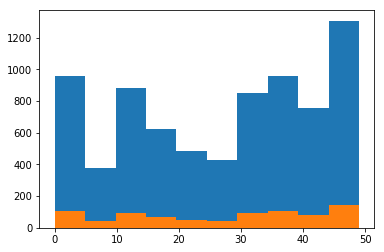

In [11]:
plt.hist(train_generator.classes)
plt.hist(validation_generator.classes)

In [12]:
from keras.applications.xception import Xception
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense

base_model = Xception(include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', name="dense_1024")(x)
predictions = Dense(num_classes, activation='softmax', name="predictions")(x)

model = Model(inputs=base_model.input, outputs=predictions)

Instructions for updating:
Colocations handled automatically by placer.
83689472/83683744 [==============================] - 1s 0us/step


In [13]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_1
13 block2_pool
14 batch_normalization_1
15 add_1
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_2
23 block3_pool
24 batch_normalization_2
25 add_2
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_3
33 block4_pool
34 batch_normalization_3
35 add_3
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_4
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_sepcon

In [14]:
# freeze some layers, only train the last blocks
for layer in base_model.layers[:31]:
    layer.trainable = True
for layer in base_model.layers[86:]:
    layer.trainable = True

In [15]:
%%time
from keras.callbacks import *
from keras.optimizers import *

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, min_lr=0.001)
]

model.compile(optimizer=SGD(lr=0.01),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.fit_generator(
    train_generator, 
    callbacks=callbacks, 
    validation_data=validation_generator, 
    epochs=16,
    steps_per_epoch=500,
    validation_steps=80,
    workers=2)

Instructions for updating:
Use tf.cast instead.
Epoch 1/14
500/500 [==============================] - 235s 471ms/step - loss: 3.2617 - acc: 0.1982 - val_loss: 2.6980 - val_acc: 0.3473
Epoch 2/14
500/500 [==============================] - 217s 434ms/step - loss: 2.3281 - acc: 0.4210 - val_loss: 1.9262 - val_acc: 0.5110
Epoch 3/14
500/500 [==============================] - 217s 434ms/step - loss: 1.7066 - acc: 0.5578 - val_loss: 1.4889 - val_acc: 0.6044
Epoch 4/14
500/500 [==============================] - 215s 430ms/step - loss: 1.3319 - acc: 0.6466 - val_loss: 1.2096 - val_acc: 0.6716
Epoch 5/14
500/500 [==============================] - 216s 433ms/step - loss: 1.0592 - acc: 0.7085 - val_loss: 1.1117 - val_acc: 0.6988
Epoch 6/14
500/500 [==============================] - 216s 431ms/step - loss: 0.8296 - acc: 0.7692 - val_loss: 0.9575 - val_acc: 0.7261
Epoch 7/14
500/500 [==============================] - 214s 427ms/step - loss: 0.6741 - acc: 0.8167 - val_loss: 0.9126 - val_acc: 0.7463


In [16]:
model.load_weights('best_model.h5')

model.evaluate_generator(datagen.flow_from_directory(
        img_dir,
        target_size=img_size,
        batch_size=16,
        class_mode='categorical'), steps=100)

Found 8446 images belonging to 50 classes.


[0.22784342849627137, 0.94375]

In [17]:
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.models import Model

class ImgVectorizer:

    def __init__(self, model, dense_layer_name):
        self.intermediate_layer_model = Model(
            inputs=model.input, 
            outputs=model.get_layer(dense_layer_name).output
        )

    def to_vector(self, imgs):
        """ Gets a vector embedding from an image
        :param image_path: path to image on filesystem
        :returns: numpy ndarray
        """
        batch = np.array(imgs)
        intermediate_output = self.intermediate_layer_model.predict(batch)
        return intermediate_output
    
vectorizer = ImgVectorizer(model=model, dense_layer_name="dense_1024")

In [18]:
def batched(batch_size, iterable):
    batch = []
    for item in iterable:
        batch.append(item)
        if len(batch) == batch_size:
            yield batch
            batch = []
    if len(batch) > 0:
        yield batch

In [19]:
import glob
import re

p = re.compile(".*/images/(?P<name>.*)/(?P<img>.*)\.jpg")

def img_dict_generator():
    for file in glob.glob(img_dir + '*/*'):
        match = p.match(file)
        if match:
            artist = p.match(file).group("name")
            yield {'artist': artist, 'file': file, 'vector': []}
        
df = pd.DataFrame(img_dict_generator())

In [20]:
%%time

def add_vector_field(dataframe):
    dataframe['file'].values

for indexes in batched(16, df.index):
    df_batch = df.loc[indexes]
    imgs = [load_img(file) for file in df_batch['file'].values]
    vectors = vectorizer.to_vector(imgs)
    df_batch['vector'] = [tuple(list) for list in vectors]
    df.update(df_batch)

CPU times: user 2min 35s, sys: 36.3 s, total: 3min 11s
Wall time: 3min 8s


In [21]:
df.to_hdf('df_with_vectors.h5', key="vectors")
df.to_csv('df_with_vectors.csv')

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:1996: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block0_values] [items->['artist', 'file', 'vector']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)
